In [1]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain_huggingface langchain-core bitsandbytes text-generation transformers evaluate rouge_score bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━

In [20]:
import os
from google.colab import userdata

os.environ["LANGSMITH_TRACING_V2"] = userdata.get('LANGSMITH_TRACING_V2')
os.environ["LANGSMITH_ENDPOINT"] = userdata.get('LANGSMITH_ENDPOINT')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = userdata.get('LANGCHAIN_PROJECT')
os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [3]:
import transformers, torch
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline

# HuggingFaceH4/zephyr-7b-beta, mistralai/Mixtral-8x7B-Instruct-v0.1
def get_chat_model(model_id: str) -> ChatHuggingFace:
  llm = HuggingFacePipeline.from_model_id(
      model_id=model_id,
      task="text-generation",
      pipeline_kwargs=dict(
          max_new_tokens=512,
          do_sample=False,
          repetition_penalty=1.03,
          return_full_text=False,
      ),
      model_kwargs={"quantization_config": quantization_config},
  )

  return ChatHuggingFace(llm=llm)

In [4]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

# all-MiniLM-L6-v2, all-roberta-large-v1
def get_embeddings(model_name: str) -> HuggingFaceEmbeddings:
  return HuggingFaceEmbeddings(model_name=model_name)

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

web_paths=(
    # work graphs
    "https://gpuopen.com/learn/gpu-work-graphs/gpu-work-graphs-part1/",
    "https://gpuopen.com/learn/gpu-work-graphs/gpu-work-graphs-part2/",
    "https://gpuopen.com/learn/gpu-work-graphs/gpu-work-graphs-part3/",
    # mesh shaders
    "https://gpuopen.com/learn/mesh_shaders/mesh_shaders-from_vertex_shader_to_mesh_shader/",
    "https://gpuopen.com/learn/mesh_shaders/mesh_shaders-optimization_and_best_practices/",
    "https://gpuopen.com/learn/mesh_shaders/mesh_shaders-font_and_vector_art_rendering_with_mesh_shaders/",
    "https://gpuopen.com/learn/mesh_shaders/mesh_shaders-procedural_grass_rendering/",
    "https://gpuopen.com/learn/mesh_shaders/mesh_shaders-meshlet_compression/",
    # fsr 3
    "https://gpuopen.com/learn/ue-fsr3/",
    # d3d12
    "https://gpuopen.com/learn/hellod3d12-directx-12-sdk-sample/",
    # vulkan
    "https://gpuopen.com/learn/hellovulkan-introductory-vulkan-sample/",
    "https://gpuopen.com/learn/vulkan-barriers-explained/",
    # tools
    "https://gpuopen.com/d3d12-memory-allocator/",
    "https://gpuopen.com/radeon-raytracing-analyzer/",
    "https://gpuopen.com/rmv/",
    "https://gpuopen.com/rgp/",
    "https://gpuopen.com/rga/",
    # matrix-compendium
    "https://gpuopen.com/learn/matrix-compendium/matrix-compendium-intro/",
    "https://gpuopen.com/learn/matrix-compendium/matrix-compendium-premult_lh_dx/",
    "https://gpuopen.com/learn/matrix-compendium/matrix-compendium-premult_rh/",
    "https://gpuopen.com/learn/matrix-compendium/matrix-compendium-postmult_lh/",
    "https://gpuopen.com/learn/matrix-compendium/matrix-compendium-postmult_rh_gl/",
    # other
    "https://gpuopen.com/ryzen-performance/",
    "https://gpuopen.com/learn/why-multi-resolution-geometric-representation-bvh-ray-tracing/",
    "https://gpuopen.com/learn/threadripper-for-gamedev-ue4/",
    "https://gpuopen.com/learn/optimizing-gpu-occupancy-resource-usage-large-thread-groups/",
    "https://gpuopen.com/learn/amd-gcn-assembly-cross-lane-operations/",
    )

loader = WebBaseLoader(
    web_paths=web_paths,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("body")
        )
    ),
)

print(f"#####################Loading docs...")
gpuopen_docs = loader.load()
print(f"#####################Loaded {len(gpuopen_docs)}/{len(web_paths)} docs.")

#####################Loading docs...
#####################Loaded 27/27 docs.


In [6]:
import random
from langchain_core.vectorstores import InMemoryVectorStore, VectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter

def get_vector_store(docs, embeddings, chunk_size=1000) -> VectorStore:
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size / 5))
  all_splits = text_splitter.split_documents(docs)
  print(f"#####################Generated {len(all_splits)} splits.")

  # random_splits = random.sample(all_splits, min(3, len(all_splits)))
  # for i, split in enumerate(random_splits):
  #     print(f"#####################Example split {i+1}:\n{split.page_content}\n")

  return InMemoryVectorStore.from_documents(all_splits, embeddings)

In [7]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(
    "You are an assistant for question-answering tasks and an expert in GPU programming and AMD's GPUOpen documentation. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. Keep the answer short. "
    "Answer the following question based on the provided context:\n\n"
    "Context: {context}\n\n"
    "Question: {question}\n\n"
    "Answer:"
)

In [8]:
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt_template.invoke({"question": state["question"], "context": docs_content})
    response = chat_model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

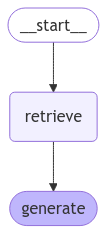

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# response = graph.invoke({"question": "What are the prerequisites for using a Work Graph?"})
# print(response["answer"])
# print(response)

In [11]:
qa_pairs = [
    ("What are the prerequisites for using a Work Graph?", "You need a version of the Microsoft DirectX® shader compiler and Agility SDK runtime that supports GPU Work Graphs, a compatible graphics card (e.g., AMD Radeon™ RX 7000 Series Graphics Card), and an AMD driver with GPU Work Graph support."),
    ("How can you validate that the current DirectX 12 stack supports Work Graphs?", "You can use CheckFeatureSupport with D3D12_FEATURE_D3D12_OPTIONS21 and check that Options.WorkGraphsTier is not equal to D3D12_WORK_GRAPHS_TIER_NOT_SUPPORTED."),
    ("What is the purpose of the D3D12_SET_WORK_GRAPH_FLAG_INITIALIZE flag, and when should it be used?", "The D3D12_SET_WORK_GRAPH_FLAG_INITIALIZE flag must be set at least once per unique program to initialize the Work Graph. However, it should not be specified during every dispatch for Work Graphs that will run multiple times, as it comes with performance costs."),
    ("What is the purpose of DispatchNodeInputRecord<> in Work Graphs?", "DispatchNodeInputRecord<> is a semantic used in Work Graph nodes to retrieve Input Records from the driver-maintained queue. These Input Records serve as parameters for individual invocations of a node, enabling dynamic data input for shader execution."),
    ("How do you specify Input Records for a Work Graph in DirectX 12?", "To specify Input Records, you need to define a structure representing the Input Record (e.g., `struct InputRecord`), populate it with data, and reference it in the `D3D12_DISPATCH_GRAPH_DESC` structure. For example, set `DispatchGraphDesc.NodeCPUInput.pRecords` to the address of the Input Record and provide the record's stride in bytes using `DispatchGraphDesc.NodeCPUInput.RecordStrideInBytes`."),
    ("What is the function of the SV_DispatchGrid semantic in Input Records?", "The SV_DispatchGrid semantic allows you to dynamically specify the dispatch grid size for a given Work Graph node. This enables developers to control the number of thread groups required for a dispatch dynamically, instead of hardcoding the grid size."),
    ("How are Output Records used in Work Graph nodes?", "Output Records are used to store the results of a node's execution. They can be dynamically defined and accessed by subsequent nodes in the graph, enabling the Work Graph to pass data between nodes seamlessly."),
    ("What is the importance of the D3D12_DISPATCH_WORK_GRAPH_DESC structure?", "The D3D12_DISPATCH_WORK_GRAPH_DESC structure defines the parameters for dispatching a Work Graph, including the grid size, Input Records, and any flags like D3D12_DISPATCH_WORK_GRAPH_FLAG_INITIALIZE to manage initialization."),
    ("What is the purpose of referencing Work Graph entrypoints by name instead of index?", "Referencing Work Graph entrypoints by name instead of by index improves collaboration and scalability, especially in iterative environments or when multiple developers are working on the same content. It avoids confusion caused by changes in index-based locations of entrypoints and allows for easier updates. This can be achieved by building a map from entrypoint names to indices, as shown in the example code using C++ STL."),
    ("How does [MaxRecordsSharedWith()] improve memory usage in Work Graph nodes?", "[MaxRecordsSharedWith()] improves memory usage by allowing nodes to share a single maximum record allocation between outputs that cannot occur simultaneously. For example, if Node B can output to either Node B (recursively) or Node C, but not both at the same time, [MaxRecordsSharedWith()] ensures that only the required memory is allocated, reducing waste and avoiding hitting 'MaxRecords ceiling' limits."),
]

In [56]:
from evaluate import load
from transformers import pipeline

def evaluate_answer_quality(config, qa_pairs):
    bleu_metric = load('bleu')
    rouge_metric = load('rouge')
    bertscore_metric = load('bertscore')

    predictions = []
    references = []

    for question, ground_truth in qa_pairs:
        response = graph.invoke({"question": question})
        generated_answer = response["answer"]
        # generated_answer = "To use a Work Graph, you must have a Microsoft DirectX® shader compiler and Agility SDK runtime that include GPU Work Graph support, along with a compatible GPU such as an AMD Radeon™ RX 7000 Series graphics card and an AMD driver that enables GPU Work Graph functionality. DirectX® is a collection of application programming interfaces (APIs) designed to make it easier for developers to access the full power of a Windows-based PC, especially for applications like video games and graphic-intensive software. DirectX® shader compilers are vital in this system, as they take high-level shader code, which is written by developers to handle graphical tasks such as lighting and texture mapping, and compile it into low-level instructions that the GPU can execute efficiently."
        # generated_answer = "To use a Work Graph, you must have a Microsoft DirectX® shader compiler and Agility SDK runtime that include GPU Work Graph support, along with a compatible GPU such as an AMD Radeon™ RX 7000 Series graphics card and an AMD driver that enables GPU Work Graph functionality."

        # bleu = bleu_metric.compute(predictions=[generated_answer], references=[ground_truth])
        # rouge = rouge_metric.compute(predictions=[generated_answer], references=[ground_truth])
        # bertscore = bertscore_metric.compute(predictions=[generated_answer], references=[ground_truth], rescale_with_baseline=True, lang="en")

        predictions.append(generated_answer)
        references.append(ground_truth)

        # print(bleu)
        # print(rouge)
        # print(bertscore)

    bleu = bleu_metric.compute(predictions=predictions, references=references)
    rouge = rouge_metric.compute(predictions=predictions, references=references)
    bertscore = bertscore_metric.compute(predictions=predictions, references=references, rescale_with_baseline=True, lang="en")

    return {
        "questions": [x[0] for x in qa_pairs],
        "predictions": predictions,
        "references": references,
        # "question": question,
        # "ground_truth": ground_truth,
        # "generated_answer": generated_answer,
        "bleu": bleu,
        "rouge": rouge,
        "bertscore": bertscore,
    }

    return results

In [13]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_metrics(results):
#     # Extract BLEU scores
#     bleu_avg = [r['bleu']['bleu'] for r in results]
#     bleu_precisions = [r['bleu']['precisions'] for r in results]
#     bleu_brevity_penalty = [r['bleu']['brevity_penalty'] for r in results]
#     bleu_length_ratio = [r['bleu']['length_ratio'] for r in results]

#     # Extract ROUGE scores
#     rouge1 = [r['rouge']['rouge1'] for r in results]
#     rouge2 = [r['rouge']['rouge2'] for r in results]
#     rougeL = [r['rouge']['rougeL'] for r in results]
#     rougeLsum = [r['rouge']['rougeLsum'] for r in results]

#     # Extract BERTScore metrics
#     precision = [r['bertscore']['precision'][0] for r in results]
#     recall = [r['bertscore']['recall'][0] for r in results]
#     f1 = [r['bertscore']['f1'][0] for r in results]

#     # Create subplots
#     fig, axs = plt.subplots(3, 2, figsize=(14, 14))

#     # Plot BLEU scores
#     axs[0, 0].bar(range(len(bleu_avg)), bleu_avg, label='BLEU', color='blue')
#     axs[0, 0].set_title('BLEU Scores')
#     axs[0, 0].set_xlabel('QA Pairs')
#     axs[0, 0].set_ylabel('BLEU Score')

#     axs[0, 1].bar(range(len(bleu_precisions)), [p[0] for p in bleu_precisions], label='Precision', color='green')
#     axs[0, 1].set_title('BLEU Precision')
#     axs[0, 1].set_xlabel('QA Pairs')
#     axs[0, 1].set_ylabel('Precision')

#     # Plot ROUGE scores
#     axs[1, 0].bar(range(len(rouge1)), rouge1, label='ROUGE-1', color='red')
#     axs[1, 0].set_title('ROUGE-1 Scores')
#     axs[1, 0].set_xlabel('QA Pairs')
#     axs[1, 0].set_ylabel('ROUGE-1 Score')

#     axs[1, 1].bar(range(len(rouge2)), rouge2, label='ROUGE-2', color='orange')
#     axs[1, 1].set_title('ROUGE-2 Scores')
#     axs[1, 1].set_xlabel('QA Pairs')
#     axs[1, 1].set_ylabel('ROUGE-2 Score')

#     # Plot BERTScore metrics
#     axs[2, 0].bar(range(len(precision)), precision, label='Precision', color='purple')
#     axs[2, 0].set_title('BERTScore Precision')
#     axs[2, 0].set_xlabel('QA Pairs')
#     axs[2, 0].set_ylabel('Precision')

#     axs[2, 1].bar(range(len(recall)), recall, label='Recall', color='cyan')
#     axs[2, 1].set_title('BERTScore Recall')
#     axs[2, 1].set_xlabel('QA Pairs')
#     axs[2, 1].set_ylabel('Recall')

#     # Adjust layout and show the plot
#     plt.tight_layout()
#     plt.show()

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(results, model_names=None):
    if model_names is None:
        model_names = [f'Model {i+1}' for i in range(len(results))]

    # Extract BLEU scores
    bleu_avg = [r['bleu']['bleu'] for r in results]
    bleu_precisions = [np.mean(r['bleu']['precisions']) for r in results]
    bleu_brevity_penalty = [r['bleu']['brevity_penalty'] for r in results]
    bleu_length_ratio = [r['bleu']['length_ratio'] for r in results]

    # Extract ROUGE scores
    rouge1 = [r['rouge']['rouge1'] for r in results]
    rouge2 = [r['rouge']['rouge2'] for r in results]
    rougeL = [r['rouge']['rougeL'] for r in results]
    rougeLsum = [r['rouge']['rougeLsum'] for r in results]

    # Extract BERTScore metrics (averaged across samples)
    bertscore_precision = [np.mean(r['bertscore']['precision']) for r in results]
    bertscore_recall = [np.mean(r['bertscore']['recall']) for r in results]
    bertscore_f1 = [np.mean(r['bertscore']['f1']) for r in results]

    # Create subplots
    fig, axs = plt.subplots(4, 2, figsize=(14, 18))

    # BLEU Scores
    axs[0, 0].bar(model_names, bleu_avg, color='blue')
    axs[0, 0].set_title('BLEU Score')

    axs[0, 1].bar(model_names, bleu_precisions, color='green')
    axs[0, 1].set_title('BLEU Precision')

    # ROUGE Scores
    axs[1, 0].bar(model_names, rouge1, color='red')
    axs[1, 0].set_title('ROUGE-1')

    axs[1, 1].bar(model_names, rouge2, color='orange')
    axs[1, 1].set_title('ROUGE-2')

    axs[2, 0].bar(model_names, rougeL, color='brown')
    axs[2, 0].set_title('ROUGE-L')

    axs[2, 1].bar(model_names, bertscore_f1, color='cyan')
    axs[2, 1].set_title('BERTScore F1')

    axs[3, 0].bar(model_names, bertscore_precision, color='yellow')
    axs[3, 0].set_title('BERTScore Precision')

    axs[3, 1].bar(model_names, bertscore_recall, color='magenta')
    axs[3, 1].set_title('BERTScore Recall')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [83]:
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
)

configurations = [
    {
        "model_id": "HuggingFaceH4/zephyr-7b-beta",
        "quantization_config": quantization_config,
        "embeddings_model_name": "sentence-transformers/all-mpnet-base-v2",
        "chunk_size": 1000
    },
    {
        "model_id": "mistralai/Ministral-8B-Instruct-2410",
        "quantization_config": quantization_config,
        "embeddings_model_name": "sentence-transformers/all-mpnet-base-v2",
        "chunk_size": 1000
    },
    {
        "model_id": "mistralai/Ministral-8B-Instruct-2410",
        "quantization_config": quantization_config,
        "embeddings_model_name": "thenlper/gte-small",
        "chunk_size": 1000
    },
    {
        "model_id": "mistralai/Ministral-8B-Instruct-2410",
        "quantization_config": quantization_config,
        "embeddings_model_name": "thenlper/gte-small",
        "chunk_size": 2000
    }
]

In [84]:
chat_model = None
embeddings = None
vector_store = None
chunk_size = None

In [85]:
config_results = []

for i, config in enumerate(configurations):
  print(f"###Config: {config}")

  if chat_model is None or config["model_id"] != chat_model.model_id:
      chat_model = get_chat_model(config["model_id"])

  if embeddings is None or config["embeddings_model_name"] != embeddings.model_name or chunk_size is None or config["chunk_size"] != chunk_size:
      chunk_size = config["chunk_size"]
      embeddings = get_embeddings(config["embeddings_model_name"])
      vector_store = get_vector_store(gpuopen_docs, embeddings, chunk_size)

  config_results.append(evaluate_answer_quality(graph, qa_pairs))

###Config: {'model_id': 'HuggingFaceH4/zephyr-7b-beta', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
, 'embeddings_model_name': 'sentence-transformers/all-mpnet-base-v2', 'chunk_size': 1000}


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0


#####################Generated 462 splits.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Config: {'model_id': 'mistralai/Ministral-8B-Instruct-2410', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
, 'embeddings_model_name': 'sentence-transformers/all-mpnet-base-v2', 'chunk_size': 1000}


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Config: {'model_id': 'mistralai/Ministral-8B-Instruct-2410', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
, 'embeddings_model_name': 'thenlper/gte-small', 'chunk_size': 1000}
#####################Generated 462 splits.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Config: {'model_id': 'mistralai/Ministral-8B-Instruct-2410', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
, 'embeddings_model_name': 'thenlper/gte-small', 'chunk_size': 2000}
#####################Generated 219 splits.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
config_results

[{'questions': ['What are the prerequisites for using a Work Graph?',
   'How can you validate that the current DirectX 12 stack supports Work Graphs?',
   'What is the purpose of the D3D12_SET_WORK_GRAPH_FLAG_INITIALIZE flag, and when should it be used?',
   'What is the purpose of DispatchNodeInputRecord<> in Work Graphs?',
   'How do you specify Input Records for a Work Graph in DirectX 12?',
   'What is the function of the SV_DispatchGrid semantic in Input Records?',
   'How are Output Records used in Work Graph nodes?',
   'What is the importance of the D3D12_DISPATCH_WORK_GRAPH_DESC structure?',
   'What is the purpose of referencing Work Graph entrypoints by name instead of index?',
   'How does [MaxRecordsSharedWith()] improve memory usage in Work Graph nodes?'],
  'predictions': ['To use a Work Graph, you need:\n- A version of the Microsoft DirectX® shader compiler and Agility SDK runtime that supports GPU Work Graphs.\n- An AMD Radeon™ RX 7000 Series Graphics Card.\n- An AMD 

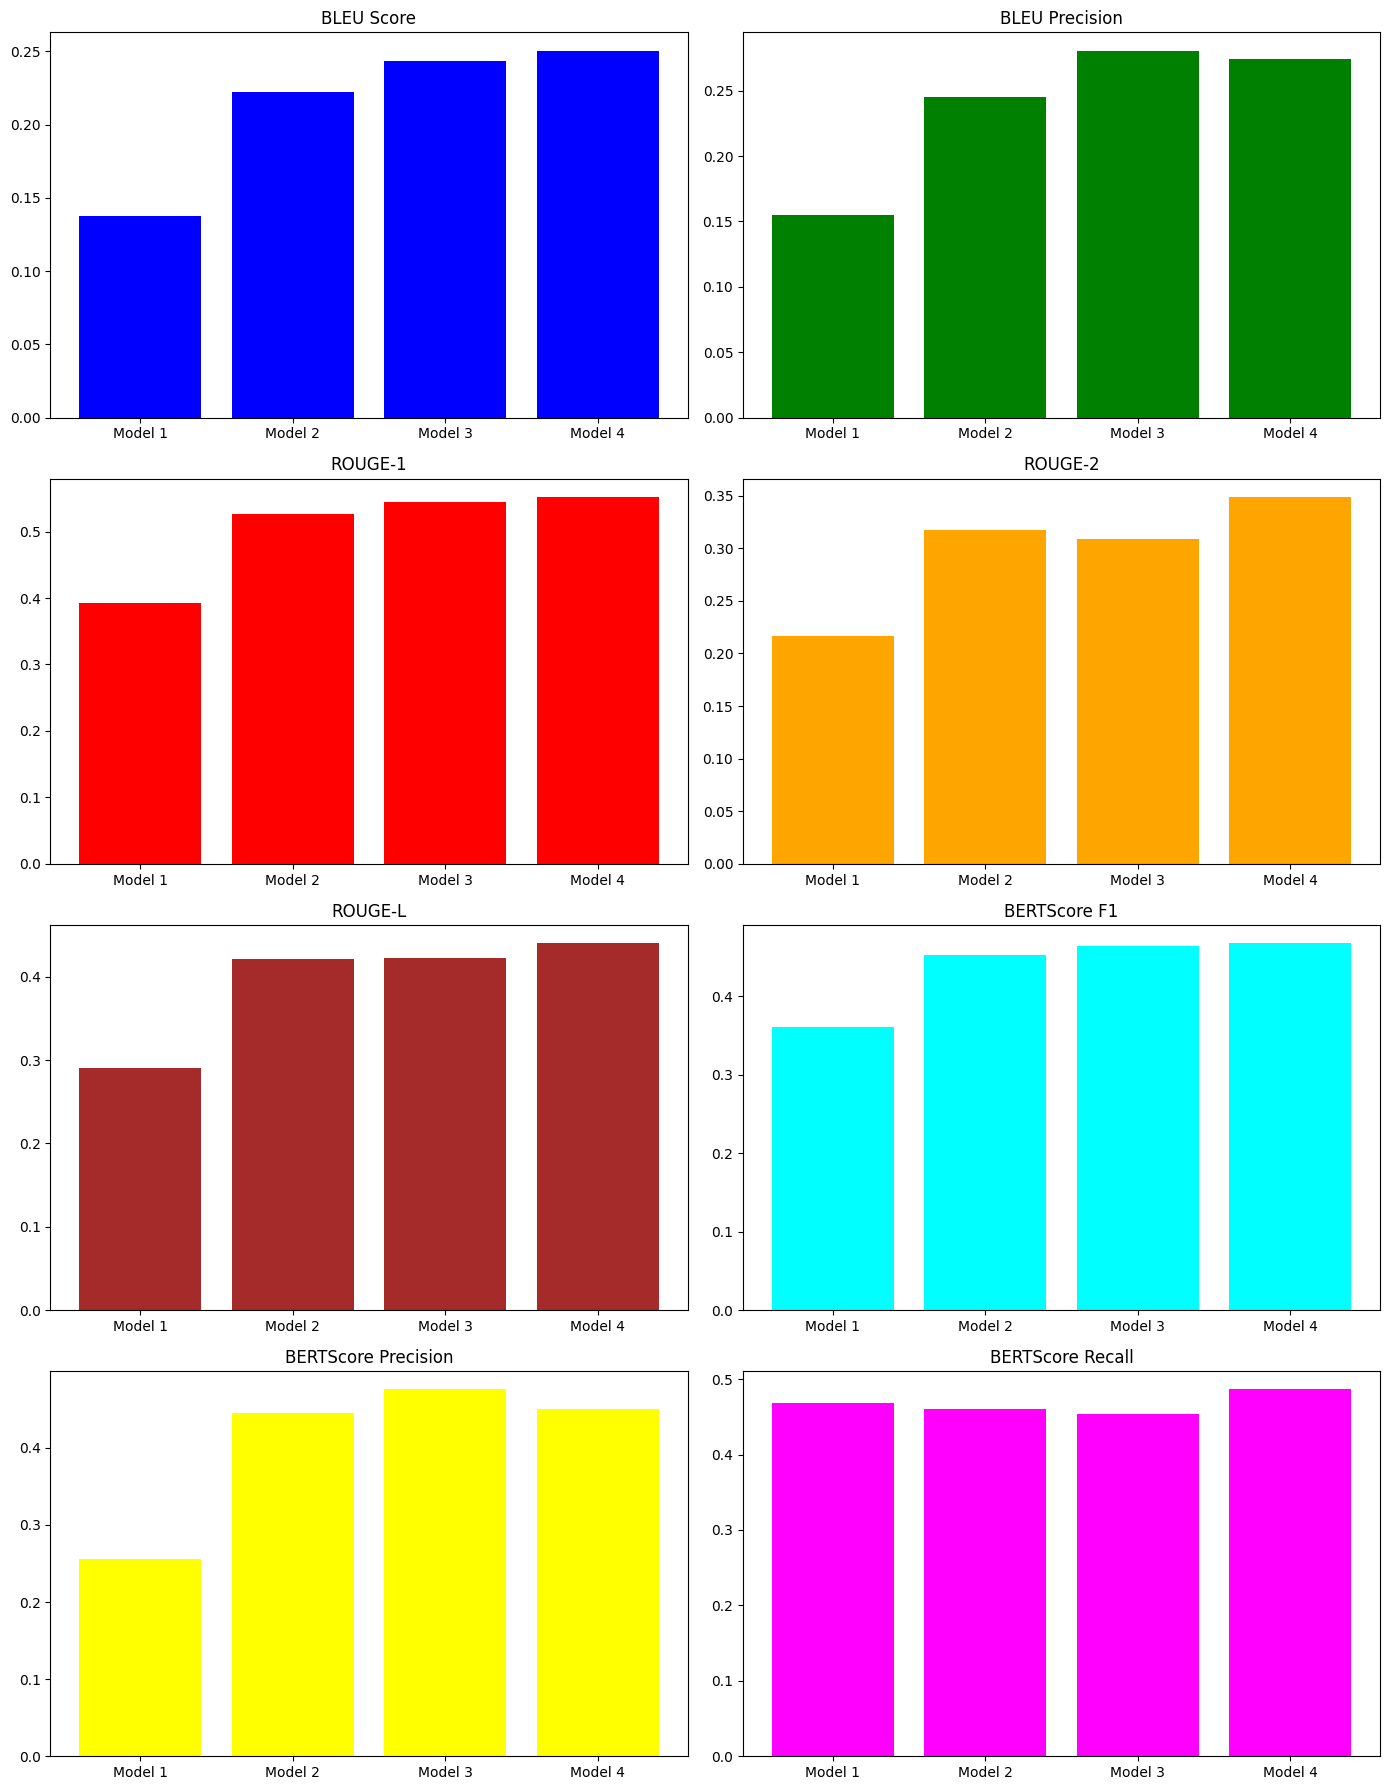

In [86]:
plot_metrics(config_results)

In [87]:
response = graph.invoke({"question": "Can you explain to me how barriers work in Vulkan?"})
print(response)
response["answer"]

'In Vulkan, barriers are synchronization primitives used to control the order of operations between different command buffers and to ensure proper data consistency. Barriers can be used to enforce dependencies between different stages of the rendering pipeline, such as between compute and graphics operations, or to ensure that certain operations are completed before others begin. They are essential for managing data dependencies and avoiding race conditions in multi-threaded environments.'

TODO:

test HF models, quantization, encoders, db search, parameters, returned chunks?

RecursiveCharacterTextSplitter: chunk_size + chunk_overlap

metrics: normal, bleu, rouge (recall), bert_score

# Sources

https://huggingface.co/learn/cookbook/en/rag_evaluation

https://docs.confident-ai.com/guides/guides-rag-evaluation

https://www.pinecone.io/learn/series/rag/rerankers/

https://github.com/Tiiiger/bert_score/blob/master/journal/rescale_baseline.md